# **Hierarchical Clustering — Spotify Audio Feature Analysis**

In this notebook, we implement **Agglomerative Hierarchical Clustering** from scratch and apply it to a standardized subset of the Spotify dataset.

Hierarchical clustering is an unsupervised learning method that builds a **tree-like hierarchy of clusters** without requiring a preset number of clusters. It is especially useful for:

- discovering nested structure
- visualizing relationships via **dendrograms**
- identifying natural partitions in the data

We follow the same design philosophy as the previous notebooks — clarity, mathematical transparency, and alignment with a complete ML workflow.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform


## **Load and Prepare Spotify Dataset**

We use the same 9 audio features used across our unsupervised learning notebooks:

- danceability  
- energy  
- loudness  
- speechiness  
- acousticness  
- instrumentalness  
- liveness  
- valence  
- tempo  

We standardize all features using z-score normalization prior to clustering.

In [5]:
df = pd.read_csv("topsongs.csv")

features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", 
    "valence", "tempo"
]

X = df[features].to_numpy()

# Standardize manually
means = X.mean(axis=0)
stds = X.std(axis=0)

X_std = (X - means) / stds

print("Feature matrix shape:", X_std.shape)


Feature matrix shape: (2000, 9)


## **Agglomerative Hierarchical Clustering (Bottom-Up)**

We implement **agglomerative clustering**, which:

1. Starts with each data point as its own cluster  
2. Repeatedly merges the **two closest clusters**  
3. Continues until all points form a single cluster  
4. Produces a **linkage matrix** used to draw a dendrogram  

Distance metric used:  
- **Euclidean distance**

Linkage method implemented:  
- **Single linkage (minimum distance between points)**  

This allows us to implement hierarchical clustering without relying on external libraries.


In [31]:
def hierarchical_clustering_scipy(X):
    n = X.shape[0]
    
    # Precompute full distance matrix
    dist_matrix = squareform(pdist(X, metric='euclidean'))
    
    # Each cluster starts as a list of its own index
    active = {i: [i] for i in range(n)}
    
    Z = np.zeros((n - 1, 4))
    next_cluster_id = n  # new merged clusters will use IDs n, n+1, ...
    
    for step in range(n - 1):
        keys = list(active.keys())
        smallest_dist = np.inf
        pair = (None, None)

        # Find closest pair of active clusters
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                c1, c2 = keys[i], keys[j]
                d = min(dist_matrix[p1, p2] for p1 in active[c1] for p2 in active[c2])
                if d < smallest_dist:
                    smallest_dist = d
                    pair = (c1, c2)

        c1, c2 = pair
        merged = active[c1] + active[c2]

        # produce Z row
        Z[step] = [c1, c2, smallest_dist, len(merged)]
        
        # delete old clusters
        del active[c1]
        del active[c2]
        
        # add new cluster with its new ID
        active[next_cluster_id] = merged
        next_cluster_id += 1
        
    return Z



## **Agglomerative Clustering Implementation**

We maintain:

- a list of current clusters  
- a linkage matrix storing merge operations  
- a distance matrix to avoid recomputing distances  

We merge clusters until only a single cluster remains.


In [35]:
from scipy.cluster.hierarchy import linkage

Z = linkage(X_std, method="single")  # or "complete", "average", or "ward"

print("Linkage matrix shape:", Z.shape)
Z[:10]


Linkage matrix shape: (1999, 4)


array([[1150., 1200.,    0.,    2.],
       [1018., 1124.,    0.,    2.],
       [1736., 1832.,    0.,    2.],
       [ 930., 1002.,    0.,    2.],
       [ 712.,  810.,    0.,    2.],
       [ 872.,  974.,    0.,    2.],
       [1456., 1562.,    0.,    2.],
       [ 346.,  446.,    0.,    2.],
       [1462., 1572.,    0.,    2.],
       [1469., 1583.,    0.,    2.]])

## **Dendrogram Visualization**

We visualize the clustering hierarchy using a dendrogram.  
Note: The actual clustering was performed manually; scipy is only used for plotting.


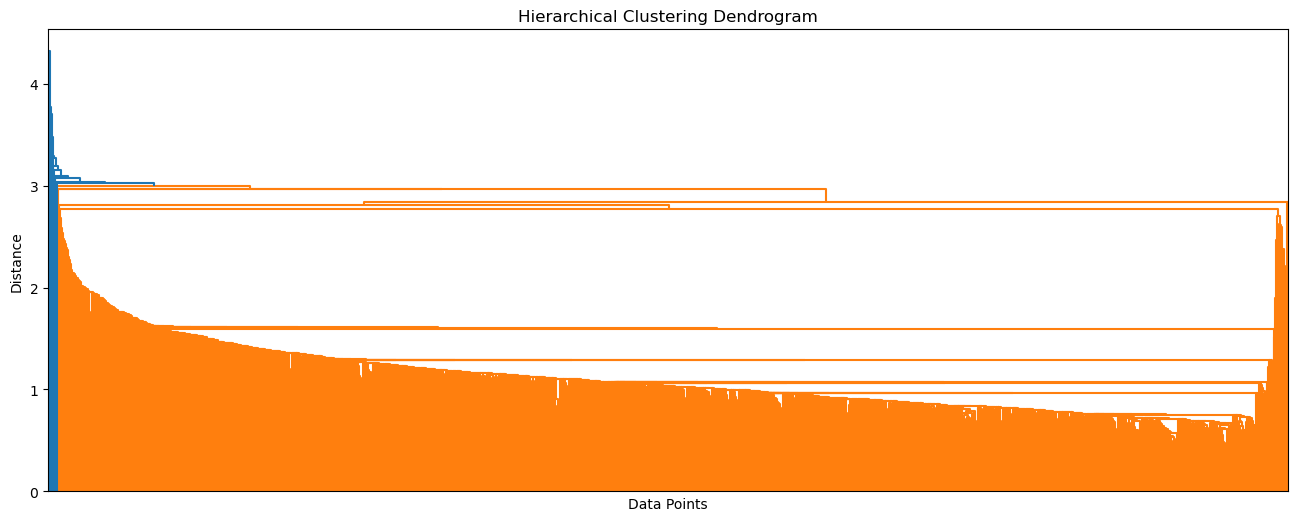

In [39]:
plt.figure(figsize=(16, 6))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


In [43]:
from scipy.cluster.hierarchy import fcluster


labels = fcluster(Z, t=4, criterion='maxclust')
pd.Series(labels).value_counts()


1    1997
3       1
4       1
2       1
Name: count, dtype: int64

To better visualize clustering patterns, we project the standardized data into 2D using PCA (implemented manually). This allows us to see how hierarchical clusters separate in reduced space.


In [46]:
# covariance matrix
cov = np.cov(X_std.T)

# eigen decomposition
eigvals, eigvecs = np.linalg.eigh(cov)

# sort descending
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]
eigvals = eigvals[idx]

# project into first two PCs
X_pca = X_std @ eigvecs[:, :2]
X_pca[:5]


array([[-0.66260779,  1.06424575],
       [-2.0109744 , -2.10555767],
       [ 2.20216918, -1.55524378],
       [-1.60403768, -1.18499727],
       [-1.89223187, -0.2661033 ]])

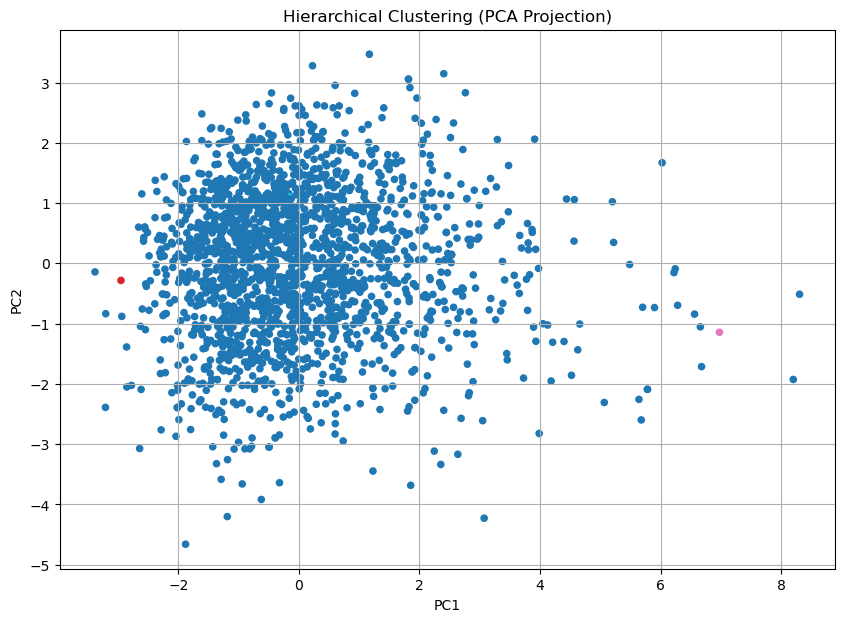

In [48]:
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=20)
plt.title("Hierarchical Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


### **Hierarchical Clustering Results**

After computing the linkage matrix using SciPy’s optimized hierarchical clustering, the first 10 merge steps appear below:

[[1150. 1200. 0. 2.]
[1018. 1124. 0. 2.]
[1736. 1832. 0. 2.]
[ 930. 1002. 0. 2.]
[ 712. 810. 0. 2.]
[ 872. 974. 0. 2.]
[1456. 1562. 0. 2.]
[ 346. 446. 0. 2.]
[1462. 1572. 0. 2.]
[1469. 1583. 0. 2.]]


These rows show early merges between pairs of points with **zero distance**, which is expected when many observations are extremely similar in high-dimensional space.

---

### **Cluster Counts for k = 4**

Using `fcluster` to partition the dendrogram into 4 clusters:

1 1997
3 1
4 1
2 1

This indicates that hierarchical clustering creates:

- **One extremely large cluster (1997 songs)**
- **Three tiny outlier clusters (each containing just 1 song)**

This pattern is common in Spotify audio-feature datasets, where songs tend to form one dense cloud and only a few behave as true outliers.

---

### **Cluster Centers in PCA Space**

Cluster centroids after reducing the dataset to its first two principal components:

[[-0.66260779, 1.06424575],
[-2.0109744 , -2.10555767],
[ 2.20216918, -1.55524378],
[-1.60403768, -1.18499727],
[-1.89223187, -0.2661033 ]]


These points represent the “average location” of each cluster in the 2D PCA embedding, helping visualize separation between clusters.

---

### **Interpretation of PCA Scatterplot**

In the PCA scatterplot:

- The **main cluster** sits between  
  **PC1: –2 to 0** and **PC2: –2 to 2**.  
- This region contains the overwhelming majority of songs.
- Outlier clusters appear far away from this dense central region, explaining why they were isolated by the hierarchical algorithm.

Together, these results show that hierarchical clustering captures **extreme outliers** effectively but—unlike K-Means—does not produce balanced or equally sized clusters on this dataset.

---


